In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import spectral_clustering
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import networkx as nx
import seaborn as sns
from functions import *

In [2]:
from scipy.stats import kendalltau, pearsonr, spearmanr
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]
def sig_pv(x):
    if x <= 0.001:
        return 1
    return 0

# Get expressions of differential expressed proteins

In [3]:
deg_5d5vs6d5_B = pd.read_csv("../data/Proteomics/deg_5d5vs6d5_B.csv")
deg_5vs6d5_B = pd.read_csv("../data/Proteomics/deg_5vs6d5_B.csv")
deg_4d5vs6d5_B = pd.read_csv("../data/Proteomics/deg_4d5vs6d5_B.csv")
genes_5d5vs6d5_B = get_deg( deg_5d5vs6d5_B, 'log2FoldChange', 'padj', 0.5, 0.05 )
genes_5vs6d5_B = get_deg( deg_5vs6d5_B, 'log2FoldChange', 'padj', 0.5, 0.05 )
genes_4d5vs6d5_B = get_deg( deg_4d5vs6d5_B, 'log2FoldChange', 'padj', 0.5, 0.05 )

In [4]:
deGenes = list( set( genes_5d5vs6d5_B['up'] + genes_5vs6d5_B['up'] + genes_4d5vs6d5_B['up'] +\
    genes_5d5vs6d5_B['down'] + genes_5vs6d5_B['down'] + genes_4d5vs6d5_B['down'] ) )
print(len(deGenes))

895


In [35]:
proB = pd.read_excel('../data/Proteomics/Proteomics_B.xlsx')
gene_info = proB[list(proB.columns[0:5])]
geneExp = proB[ ['Accession'] + list(proB.columns[-12:])].fillna(0)
geneExp = (geneExp[geneExp.Accession.isin(deGenes)]).reset_index().drop(['index'],axis=1)# select only de genes
geneExp = geneExp.T
geneExp.columns = geneExp.iloc[0]
geneExp = (geneExp.drop(['Accession'], axis=0)).reset_index().drop(['index'],axis=1)

In [6]:
for col in geneExp.columns:
    geneExp[col] = geneExp[col].astype(float)

# Co-expression analysis: Pearson corr & Spectral clustering

In [10]:
# gene_corr = geneExp.corr(method='pearson')
# gene_corr_pv = geneExp.corr(method=pearsonr_pval)
# result = {'corr_matrix':gene_corr,'pv_matrix':gene_corr_pv}
# dump_pickle(result, '../data/Proteomics/corr_result.pkl')

In [7]:
corr_result = load_pickle('../data/Proteomics/corr_result.pkl')
M_corr, M_pv = corr_result['corr_matrix'], corr_result['pv_matrix']
M_sig = M_pv.applymap(sig_pv)
X = M_corr.iloc[:,:].values
adj_matrix = M_sig.iloc[:,:].values # p-value <= 0.001

In [8]:
nclusters = np.arange(10,66,2)
inertias = []
for nc in nclusters:
    kmeans = KMeans(n_clusters=nc, random_state=0, n_init="auto").fit( adj_matrix)
    inertias.append(kmeans.inertia_)

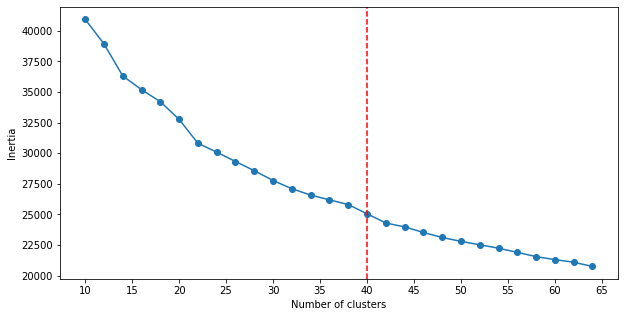

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(nclusters,inertias, marker = 'o');
ax.set_xticks( np.arange(10,66, 5) );
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Inertia')
ax.axvline(x=40, color='r', linestyle='--')

In [13]:
cluster_labels = spectral_clustering(adj_matrix, n_clusters=40,\
                assign_labels='discretize',random_state=0)
module_protein = pd.DataFrame(zip( list(M_corr.columns) ,cluster_labels), columns=['Protein','Module'])

/home/bras5181/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [31]:
module_inds = list( np.unique(module_protein['Module']) )
m_sizes = []
for ind in module_inds:
    m_sizes.append( list(module_protein['Module']).count(ind) )
    
module_info = pd.DataFrame(zip(module_inds,m_sizes), columns=['Module','size'])

Text(20, 6, 'Module 11 excluded.')

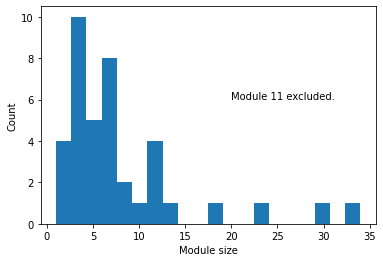

In [32]:
module_info = module_info.iloc[ list(np.arange(0,11))+list(np.arange(12,40))] # remove module 11
plt.hist(list(module_info['size']), bins=20);
plt.xlabel('Module size')
plt.ylabel('Count')
plt.text(x=20,y=6,s='Module 11 excluded.')

# Annotation of co-expressed modules

In [33]:
regulons = load_pickle('../data/Proteomics/lpwcfs1_regulons.pkl')
uniprot_info = pd.read_csv('../data/Proteomics/uniprotkb_taxonomy_id_220668.tsv',sep='\t')
kegg_annot = pd.read_excel('../data/Proteomics/All_Proteins_KEGG_query2map.xlsx')
subloc_annot = pd.read_excel('../data/Proteomics/All_Proteins_SubLoc.xlsx')

# Visualize module networks

In [38]:
def get_gene_name( uniprot_id, gene_info):
    return list( gene_info[gene_info['Accession']==uniprot_id]['Gene Name'] )[0]


def gen_network( gene_list, gene_info, corr, cluster_id, node_color ):
    G_name = 'Module_'+ str(cluster_id)
    G=nx.Graph(name = G_name )
    G.add_nodes_from( [( get_gene_name(v,gene_info ),{'color': node_color} ) for v in gene_list] )
    edge_list = []
    for i in range(len(gene_list)):
        for j in range(i+1,len(gene_list)):
            v1, v2 = gene_list[i], gene_list[j]
            if M_sig[v1][v2] != 1:
                continue
            weight = M_corr[v1][v2]
            if weight > 0:
                edge_list.append(  ( get_gene_name(v1,gene_info ), get_gene_name(v2,gene_info),\
                                    {'weight':abs(weight)*5,'edgecolor':'tab:red'} ) )
            else:
                edge_list.append(  ( get_gene_name(v1,gene_info ), get_gene_name(v2,gene_info),\
                                    {'weight':abs(weight)*5,'edgecolor':'tab:blue'} ) )
    G.add_edges_from(edge_list)
    return G

def vis_graph(G,ax):
    nodecolors = [ G.nodes.get(v)['color']for v in G.nodes]
    edgecolors = [G[u][v]['edgecolor'] for u,v in G.edges]
    weights = [G[u][v]['weight'] for u,v in G.edges]
    pos = nx.circular_layout(G)
    nx.draw( G, pos=pos,with_labels = True,node_color=nodecolors,font_weight='bold',
            edge_color=edgecolors, width=weights,ax = ax )

In [45]:
temp_list = list( module_protein[ module_protein['Module']==18]['Protein'] )
graph= gen_network(temp_list, gene_info, M_corr, 18, 'orange' )

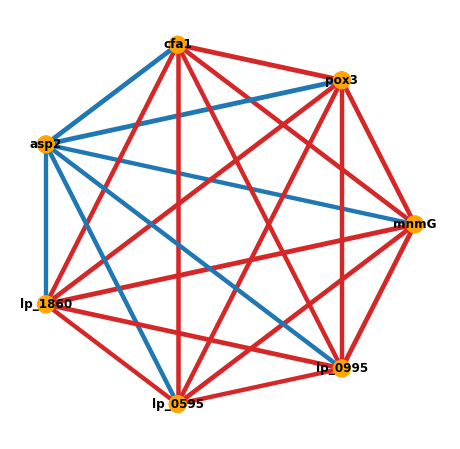

In [46]:
fig,ax = plt.subplots(figsize=(8,8))
vis_graph(graph,ax)